<a href="https://colab.research.google.com/github/muffafa/haystack_gemini_pinecone_Free_Rag_AI_Agent/blob/main/Free_Rag_AI_Agent.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [46]:
from google.colab import userdata
import google.generativeai as genai
import os

os.environ["gemini-api-key"]=userdata.get('gemini-api-key')
os.environ["pinecone-api-key"]=userdata.get('pinecone-api-key')

secrets = {
    "gemini-api-key": os.environ["gemini-api-key"],
    "pinecone-api-key": os.environ["pinecone-api-key"]
}

genai.configure(api_key=secrets["gemini-api-key"])

In [47]:
!pip install haystack-ai pypdf pinecone-haystack google-ai-haystack


In [48]:
# Downloading the embeddings model

from sentence_transformers import SentenceTransformer

model = SentenceTransformer("sentence-transformers/all-mpnet-base-v2", cache_folder="sbert_models")

model.save_pretrained(path="sbert_models/all-mpnet-base-v2", model_name="all-mpnet-base-v2")

In [49]:
# Importing the embeddings model

from haystack.components.embedders import SentenceTransformersDocumentEmbedder
# doc_embedder = SentenceTransformersDocumentEmbedder(model="sbert_models/all-mpnet-base-v2")
# doc_embedder.warm_up()

In [50]:
# from haystack import Document

# # example usage
# doc = Document(content="I love pizza!")
# result = doc_embedder.run([doc])
# print(result['documents'][0].embedding)
# print(len(result['documents'][0].embedding))

# # 768

In [51]:
from haystack.utils import Secret

from haystack import Pipeline
from haystack.components.converters import PyPDFToDocument
from haystack.components.preprocessors import DocumentCleaner
from haystack.components.preprocessors import DocumentSplitter
from haystack.components.writers import DocumentWriter

from haystack.document_stores.types import DuplicatePolicy

from haystack_integrations.document_stores.pinecone import PineconeDocumentStore

## Define Document Store and Embedder
document_store = PineconeDocumentStore(
    index="haystack-rag",
    dimension=768,
    api_key=Secret.from_token(secrets['pinecone-api-key']),
    metric='cosine'
    )

document_embedder = SentenceTransformersDocumentEmbedder(model="sbert_models/all-mpnet-base-v2")
document_embedder.warm_up()

pipeline = Pipeline()
pipeline.add_component("converter", PyPDFToDocument())
pipeline.add_component("cleaner", DocumentCleaner())
pipeline.add_component("splitter", DocumentSplitter(split_by="sentence", split_length=5))
pipeline.add_component("embedder", instance=document_embedder)
pipeline.add_component("writer", DocumentWriter(document_store=document_store, policy=DuplicatePolicy.OVERWRITE))

pipeline.connect("converter", "cleaner")
pipeline.connect("cleaner", "splitter")
pipeline.connect("splitter", "embedder")
pipeline.connect("embedder", "writer")

file_names=["/content/fidan_giblaliyeva_241295012_OT_vize.pdf"]

pipeline.run({"converter": {"sources": file_names}})

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Upserted vectors:   0%|          | 0/12 [00:00<?, ?it/s]

{'writer': {'documents_written': 12}}

In [70]:
from haystack.components.embedders import SentenceTransformersTextEmbedder
from haystack_integrations.components.retrievers.pinecone import PineconeEmbeddingRetriever

## Define Document Store and Embedder
document_store = PineconeDocumentStore(
    index="haystack-rag",
    dimension=768,
    api_key=Secret.from_token(secrets['pinecone-api-key']),
    metric='cosine'
    )


query_pipeline = Pipeline()
query_pipeline.add_component("text_embedder", SentenceTransformersTextEmbedder(model="sbert_models/all-mpnet-base-v2", progress_bar=False))
# query_pipeline.add_component("retriever", PineconeEmbeddingRetriever(document_store=document_store, top_k=10))
query_pipeline.add_component("retriever", PineconeEmbeddingRetriever(document_store=document_store))

query_pipeline.connect("text_embedder.embedding", "retriever.query_embedding")


🚅 Components
  - text_embedder: SentenceTransformersTextEmbedder
  - retriever: PineconeEmbeddingRetriever
🛤️ Connections
  - text_embedder.embedding -> retriever.query_embedding (List[float])

In [71]:
from haystack.components.builders import PromptBuilder

prompt_template = """Answer the following query based on the provided context. Answer in Turkish Language. If the context does
                     not include an answer, reply with 'I don't know'.\n
                     Query: {{query}}
                     Documents:
                     {% for doc in documents %}
                        {{ doc.content }}
                     {% endfor %}
                     Answer:
                  """

query_pipeline.add_component("prompt_builder", PromptBuilder(template=prompt_template))

In [72]:
from haystack_integrations.components.generators.google_ai import GoogleAIGeminiGenerator

gemini = GoogleAIGeminiGenerator(
    model="gemini-1.5-flash",
    api_key=Secret.from_token(secrets['gemini-api-key'])
    )

In [73]:
query_pipeline.add_component("llm", gemini)
query_pipeline.connect("retriever.documents", "prompt_builder.documents")
query_pipeline.connect("prompt_builder", "llm")


🚅 Components
  - text_embedder: SentenceTransformersTextEmbedder
  - retriever: PineconeEmbeddingRetriever
  - prompt_builder: PromptBuilder
  - llm: GoogleAIGeminiGenerator
🛤️ Connections
  - text_embedder.embedding -> retriever.query_embedding (List[float])
  - retriever.documents -> prompt_builder.documents (List[Document])
  - prompt_builder.prompt -> llm.parts (str)

In [74]:
query = "şirketlerin olumsuz tarafları nelerdir?"

results = query_pipeline.run(
    {
        "text_embedder": {"text": query},
        "prompt_builder": {"query": query},
    }
)

# print(results["llm"]["replies"][0])

# # text is so long one line so conver it

import textwrap

# Assuming `results["generator"]["replies"][0]` contains the long text
long_text = results["llm"]["replies"][0]

# Use textwrap to wrap the text at a specific width (e.g., 80 characters)
wrapped_text = textwrap.fill(long_text, width=80)

# Print the wrapped text
print(wrapped_text)

Metin, şirketlerin olumsuz yönlerine dair çeşitli örnekler sunuyor.  Bunlar
arasında; kâr odaklı yapılarının çevresel ve sosyal maliyetleri göz ardı
etmesine yol açması (örneğin Amazon'un çalışan hakları ve küçük işletmelere
etkisi), veri gizliliği ihlalleri ve manipülatif algoritmalar (Facebook ve
Google örneği), çevreye verilen zararlar (fosil yakıt şirketleri ve moda
endüstrisinin aşırı tüketim odaklı yapısı) sayılabilir.  Ayrıca, kamu
hizmetlerinin özelleştirilmesinin iklim krizi ve enerji dönüşümü bağlamında
olumsuz sonuçları da bir başka olumsuz yön olarak gösteriliyor.


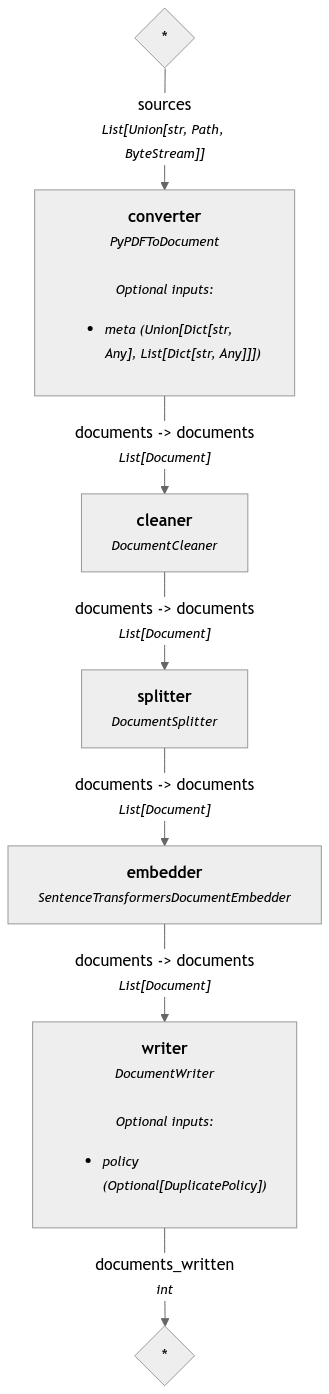

In [75]:
pipeline.show()

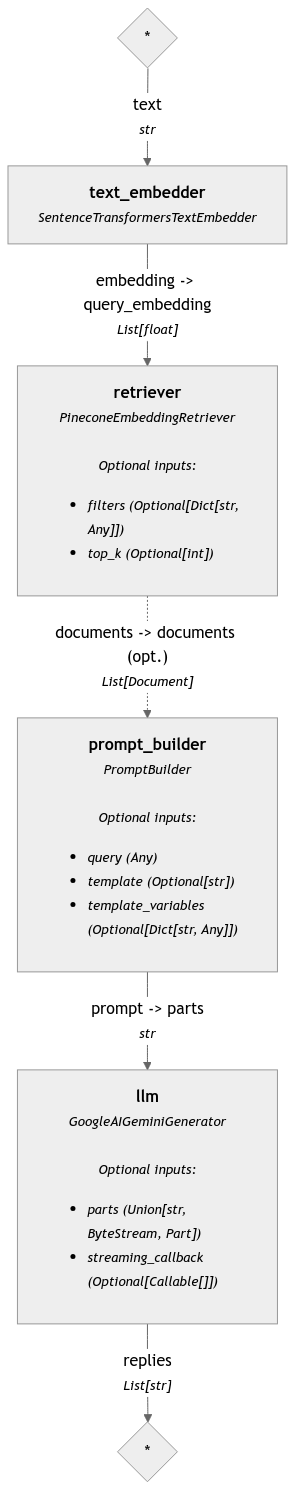

In [76]:
query_pipeline.show()